In [110]:
# regular imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import env
import wrangle as wr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format

import warnings
warnings.filterwarnings("ignore")

# Wrangling
from sklearn.model_selection import train_test_split

In [51]:
# from our acquire.py:
def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'
    
sql_query = '''
        SELECT prop.*,
        predictions_2017.logerror,
        predictions_2017.transactiondate,
        air.airconditioningdesc,
        arch.architecturalstyledesc,
        build.buildingclassdesc,
        heat.heatingorsystemdesc,
        land.propertylandusedesc,
        story.storydesc,
        type.typeconstructiondesc
        FROM properties_2017 prop
        JOIN (
            SELECT parcelid, MAX(transactiondate) AS max_transactiondate
            FROM predictions_2017
            GROUP BY parcelid
            ) pred USING(parcelid)
        JOIN predictions_2017 ON pred.parcelid = predictions_2017.parcelid
                          AND pred.max_transactiondate = predictions_2017.transactiondate
        LEFT JOIN airconditioningtype air USING(airconditioningtypeid)
        LEFT JOIN architecturalstyletype arch USING(architecturalstyletypeid)
        LEFT JOIN buildingclasstype build USING(buildingclasstypeid)
        LEFT JOIN heatingorsystemtype heat USING(heatingorsystemtypeid)
        LEFT JOIN propertylandusetype land USING(propertylandusetypeid)
        LEFT JOIN storytype story USING(storytypeid)
        LEFT JOIN typeconstructiontype type USING(typeconstructiontypeid)
        WHERE propertylandusedesc = "Single Family Residential"
            AND transactiondate <= '2017-12-31'
            AND prop.longitude IS NOT NULL
            AND prop.latitude IS NOT NULL
        '''
    
def get_zillow_data():
    df = pd.read_sql(sql_query, get_connection('zillow'))
    df = df.drop(columns='id')
    return df

In [52]:
df = get_zillow_data()

In [53]:
df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,14297519,NaN,NaN,NaN,3.50,4.00,None,NaN,3.50,NaN,...,"60,590,630,072,012.00",0.03,2017-01-01,None,None,None,None,Single Family Residential,None,None
1,17052889,NaN,NaN,NaN,1.00,2.00,None,NaN,1.00,NaN,...,"61,110,010,023,006.00",0.06,2017-01-01,None,None,None,None,Single Family Residential,None,None
2,14186244,NaN,NaN,NaN,2.00,3.00,None,NaN,2.00,NaN,...,"60,590,218,022,012.00",0.01,2017-01-01,None,None,None,None,Single Family Residential,None,None
3,12177905,NaN,NaN,NaN,3.00,4.00,None,8.00,3.00,NaN,...,"60,373,001,001,006.00",-0.10,2017-01-01,None,None,None,Central,Single Family Residential,None,None
4,12095076,1.00,NaN,NaN,3.00,4.00,None,9.00,3.00,NaN,...,"60,374,608,001,014.00",-0.00,2017-01-01,Central,None,None,Central,Single Family Residential,None,None


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52319 entries, 0 to 52318
Data columns (total 67 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      52319 non-null  int64  
 1   airconditioningtypeid         13615 non-null  float64
 2   architecturalstyletypeid      70 non-null     float64
 3   basementsqft                  47 non-null     float64
 4   bathroomcnt                   52319 non-null  float64
 5   bedroomcnt                    52319 non-null  float64
 6   buildingclasstypeid           0 non-null      object 
 7   buildingqualitytypeid         33654 non-null  float64
 8   calculatedbathnbr             52184 non-null  float64
 9   decktypeid                    389 non-null    float64
 10  finishedfloor1squarefeet      4371 non-null   float64
 11  calculatedfinishedsquarefeet  52238 non-null  float64
 12  finishedsquarefeet12          52073 non-null  float64
 13  f

In [56]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
parcelid,"52,319.00","12,996,817.91","3,350,951.35","10,711,855.00","11,510,167.50","12,578,254.00","14,130,361.00","167,687,839.00"
airconditioningtypeid,"13,615.00",2.44,3.85,1.00,1.00,1.00,1.00,13.00
architecturalstyletypeid,70.00,7.10,2.67,2.00,7.00,7.00,7.00,21.00
basementsqft,47.00,678.98,711.83,38.00,263.50,512.00,809.50,"3,560.00"
bathroomcnt,"52,319.00",2.30,1.02,0.00,2.00,2.00,3.00,18.00
bedroomcnt,"52,319.00",3.30,0.95,0.00,3.00,3.00,4.00,14.00
buildingqualitytypeid,"33,654.00",6.26,1.72,1.00,5.00,6.00,8.00,12.00
calculatedbathnbr,"52,184.00",2.31,1.02,1.00,2.00,2.00,3.00,18.00
decktypeid,389.00,66.00,0.00,66.00,66.00,66.00,66.00,66.00
finishedfloor1squarefeet,"4,371.00","1,546.29",675.34,184.00,"1,151.00","1,410.00","1,760.00","6,912.00"


(-1.0, 1.0)

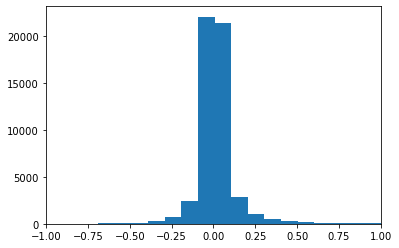

In [61]:
#Distribution of target variable
plt.hist(x=df['logerror'], bins=100)
plt.xlim(-1, 1)

In [57]:
print(f'r0ws: {df.shape[0]}')
print(f'co1umns: {df.shape[1]}')

r0ws: 52319
co1umns: 67


In [62]:
for col in df.columns:
    print(col)
    print(df[col].value_counts())

parcelid
14297519    1
17237669    1
11839030    1
17148095    1
11311690    1
           ..
14138000    1
12026029    1
14212835    1
12213446    1
12826780    1
Name: parcelid, Length: 52319, dtype: int64
airconditioningtypeid
 1.00    11873
13.00     1567
 5.00      159
11.00       16
Name: airconditioningtypeid, dtype: int64
architecturalstyletypeid
 7.00    62
 3.00     3
 2.00     2
21.00     2
 8.00     1
Name: architecturalstyletypeid, dtype: int64
basementsqft
  900.00    2
  640.00    2
  100.00    2
  515.00    2
  273.00    2
  912.00    2
  314.00    1
  819.00    1
1,809.00    1
  604.00    1
  126.00    1
  588.00    1
  786.00    1
  669.00    1
  800.00    1
  396.00    1
  112.00    1
  645.00    1
  384.00    1
1,969.00    1
  252.00    1
  600.00    1
1,218.00    1
  280.00    1
  300.00    1
  224.00    1
  512.00    1
  380.00    1
  204.00    1
  200.00    1
   90.00    1
3,112.00    1
  405.00    1
1,252.00    1
  254.00    1
3,560.00    1
  352.00    1
  168.00

Nulls By Column

Sure, using built in methods is easy enough. But what about getting our nulls by column and nulls by row?

Let's look at nulls by column. Let's start by using .isnull():

In [63]:
df.isnull().head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,False,True,True,True,False,False,True,True,False,True,...,False,False,False,True,True,True,True,False,True,True
1,False,True,True,True,False,False,True,True,False,True,...,False,False,False,True,True,True,True,False,True,True
2,False,True,True,True,False,False,True,True,False,True,...,False,False,False,True,True,True,True,False,True,True
3,False,True,True,True,False,False,True,False,False,True,...,False,False,False,True,True,True,False,False,True,True
4,False,False,True,True,False,False,True,False,False,True,...,False,False,False,False,True,True,False,False,True,True


In [64]:
df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,14297519,NaN,NaN,NaN,3.50,4.00,None,NaN,3.50,NaN,...,"60,590,630,072,012.00",0.03,2017-01-01,None,None,None,None,Single Family Residential,None,None
1,17052889,NaN,NaN,NaN,1.00,2.00,None,NaN,1.00,NaN,...,"61,110,010,023,006.00",0.06,2017-01-01,None,None,None,None,Single Family Residential,None,None
2,14186244,NaN,NaN,NaN,2.00,3.00,None,NaN,2.00,NaN,...,"60,590,218,022,012.00",0.01,2017-01-01,None,None,None,None,Single Family Residential,None,None
3,12177905,NaN,NaN,NaN,3.00,4.00,None,8.00,3.00,NaN,...,"60,373,001,001,006.00",-0.10,2017-01-01,None,None,None,Central,Single Family Residential,None,None
4,12095076,1.00,NaN,NaN,3.00,4.00,None,9.00,3.00,NaN,...,"60,374,608,001,014.00",-0.00,2017-01-01,Central,None,None,Central,Single Family Residential,None,None


In [69]:
df.isnull().sum()[:20]

parcelid                            0
airconditioningtypeid           38704
architecturalstyletypeid        52249
basementsqft                    52272
bathroomcnt                         0
bedroomcnt                          0
buildingclasstypeid             52319
buildingqualitytypeid           18665
calculatedbathnbr                 135
decktypeid                      51930
finishedfloor1squarefeet        47948
calculatedfinishedsquarefeet       81
finishedsquarefeet12              246
finishedsquarefeet13            52319
finishedsquarefeet15            52319
finishedsquarefeet50            47948
finishedsquarefeet6             52154
fips                                0
fireplacecnt                    45086
fullbathcnt                       135
dtype: int64

In [70]:
df.shape[0] # Number of rows

52319

In [71]:
(df.isnull().sum()/df.shape[0]*100)[:] # Percentage of nulls in each column

parcelid                                   0.00
airconditioningtypeid                     73.98
architecturalstyletypeid                  99.87
basementsqft                              99.91
bathroomcnt                                0.00
                                   ...         
buildingclassdesc                        100.00
heatingorsystemdesc                       35.30
propertylandusedesc                        0.00
storydesc                                 99.91
typeconstructiondesc                      99.85
Length: 67, dtype: float64

In [72]:
nulls_col = pd.DataFrame({'num_rows_missing': df.isnull().sum(), 
              'percent_rows_missing': (df.isnull().sum() / df.shape[0] * 100)})

nulls_col.sort_values(by='num_rows_missing', ascending=False).head(10)

,num_rows_missing,percent_rows_missing
finishedsquarefeet13,52319,100.00
buildingclasstypeid,52319,100.00
buildingclassdesc,52319,100.00
finishedsquarefeet15,52319,100.00
basementsqft,52272,99.91
storydesc,52272,99.91
storytypeid,52272,99.91
yardbuildingsqft26,52256,99.88
architecturalstyletypeid,52249,99.87
architecturalstyledesc,52249,99.87


### nulls_by_col function

In [73]:
def nulls_by_col(df):
    num_missing = df.isnull().sum()
    rows = df.shape[0]
    prcnt_miss = num_missing / rows * 100
    cols_missing = pd.DataFrame({'num_rows_missing': num_missing, 'percent_rows_missing': prcnt_miss})
    return cols_missing.sort_values(by='num_rows_missing', ascending=False)

Nulls by Row



In [74]:
# look at the number/percent of nulls in each row
df.isnull().sum(axis=1)

0        36
1        33
2        34
3        32
4        29
         ..
52314    34
52315    33
52316    32
52317    32
52318    34
Length: 52319, dtype: int64

In [75]:
#both NaN and None are considered as null
df.head(1)[df.head(1).isna()]

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,...,NaN,NaN,NaN,None,None,None,None,NaN,None,None


In [76]:
#into a percentage:
df.isnull().sum(axis=1) / df.shape[1] * 100

0                      53.73
1                      49.25
2                      50.75
3                      47.76
4                      43.28
                ...         
52314                  50.75
52315                  49.25
52316                  47.76
52317                  47.76
52318                  50.75
Length: 52319, dtype: float64

In [77]:
nulls_row = pd.DataFrame({'num_cols_missing': df.isnull().sum(axis=1),
              'percent_cols_missing': df.isnull().sum(axis=1)/df.shape[1]*100})

nulls_row

,num_cols_missing,percent_cols_missing
0,36,53.73
1,33,49.25
2,34,50.75
3,32,47.76
4,29,43.28
...,...,...
52314,34,50.75
52315,33,49.25
52316,32,47.76
52317,32,47.76


In [78]:
#if we wanted parcel id back in
# nulls_row = df.merge(nulls_row,
#                         left_index=True,
#                         right_index=True)[['parcelid', 'num_cols_missing', 'percent_cols_missing']]

# nulls_row

In [79]:
nulls_row.sort_values(by='num_cols_missing', ascending=False)

,num_cols_missing,percent_cols_missing
28006,48,71.64
8954,48,71.64
41347,47,70.15
13356,46,68.66
21989,45,67.16
...,...,...
44684,24,35.82
83,24,35.82
37444,24,35.82
39391,23,34.33


### nulls_by_row function

In [80]:
def nulls_by_row(df):
    num_missing = df.isnull().sum(axis=1)
    prcnt_miss = num_missing / df.shape[1] * 100
    rows_missing = pd.DataFrame({'num_cols_missing': num_missing, 'percent_cols_missing': prcnt_miss})
#     rows_missing = df.merge(rows_missing,
#                         left_index=True,
#                         right_index=True)[['parcelid', 'num_cols_missing', 'percent_cols_missing']]
    return rows_missing.sort_values(by='num_cols_missing', ascending=False)

### summarize function

In [81]:
def summarize(df):
    '''
    summarize will take in a single argument (a pandas dataframe) 
    and output to console various statistics on said dataframe, including:
    # .head()
    # .info()
    # .describe()
    # .value_counts()
    # observation of nulls in the dataframe
    '''
    print('SUMMARY REPORT')
    print('=====================================================\n\n')
    print('Dataframe head: ')
    print(df.head(3))
    print('=====================================================\n\n')
    print('Dataframe info: ')
    print(df.info())
    print('=====================================================\n\n')
    print('Dataframe Description: ')
    print(df.describe())
    num_cols = [col for col in df.columns if df[col].dtype != 'O']
    cat_cols = [col for col in df.columns if col not in num_cols]
    print('=====================================================')
    print('DataFrame value counts: ')
    for col in df.columns:
        if col in cat_cols:
            print(df[col].value_counts(), '\n')
        else:
            print(df[col].value_counts(bins=10, sort=False), '\n')
    print('=====================================================')
    print('nulls in dataframe by column: ')
    print(nulls_by_col(df))
    print('=====================================================')
    print('nulls in dataframe by row: ')
    print(nulls_by_row(df))
    print('=====================================================')

In [82]:
summarize(df)

SUMMARY REPORT


Dataframe head: 
   parcelid  airconditioningtypeid  architecturalstyletypeid  basementsqft  \
0  14297519                    NaN                       NaN           NaN   
1  17052889                    NaN                       NaN           NaN   
2  14186244                    NaN                       NaN           NaN   

           bathroomcnt           bedroomcnt buildingclasstypeid  \
0                 3.50                 4.00                None   
1                 1.00                 2.00                None   
2                 2.00                 3.00                None   

   buildingqualitytypeid    calculatedbathnbr  decktypeid  ...  \
0                    NaN                 3.50         NaN  ...   
1                    NaN                 1.00         NaN  ...   
2                    NaN                 2.00         NaN  ...   

    censustractandblock             logerror  transactiondate  \
0 60,590,630,072,012.00                 0.03       201

(-0.019, 1.8]    10494
(1.8, 3.6]       37337
(3.6, 5.4]        3714
(5.4, 7.2]         679
(7.2, 9.0]          85
(9.0, 10.8]          5
(10.8, 12.6]         3
(12.6, 14.4]         1
(14.4, 16.2]         0
(16.2, 18.0]         1
Name: bathroomcnt, dtype: int64 

(-0.015, 1.4]      746
(1.4, 2.8]        8317
(2.8, 4.2]       38512
(4.2, 5.6]        3967
(5.6, 7.0]         740
(7.0, 8.4]          24
(8.4, 9.8]           8
(9.8, 11.2]          3
(11.2, 12.6]         1
(12.6, 14.0]         1
Name: bedroomcnt, dtype: int64 

Series([], Name: buildingclasstypeid, dtype: int64) 

(0.988, 2.1]       13
(2.1, 3.2]        149
(3.2, 4.3]       8135
(4.3, 5.4]       1507
(5.4, 6.5]      10260
(6.5, 7.6]       3424
(7.6, 8.7]       8222
(8.7, 9.8]       1119
(9.8, 10.9]       230
(10.9, 12.0]      595
Name: buildingqualitytypeid, dtype: int64 

(0.982, 2.7]    36131
(2.7, 4.4]      13791
(4.4, 6.1]       2032
(6.1, 7.8]        151
(7.8, 9.5]         69
(9.5, 11.2]         8
(11.2, 12.9]        0
(

(59948352007016.984, 102636920499301.5]    52197
(102636920499301.5, 144902829897603.0]         0
(144902829897603.0, 187168739295904.5]         0
(187168739295904.5, 229434648694206.03]        0
(229434648694206.03, 271700558092507.5]        0
(271700558092507.5, 313966467490809.0]         0
(313966467490809.0, 356232376889110.5]         0
(356232376889110.5, 398498286287411.94]        0
(398498286287411.94, 440764195685713.5]        0
(440764195685713.5, 483030105084015.0]         1
Name: censustractandblock, dtype: int64 

(-4.666, -3.664]        2
(-3.664, -2.672]        0
(-2.672, -1.68]        26
(-1.68, -0.688]       109
(-0.688, 0.304]     50829
(0.304, 1.296]       1220
(1.296, 2.287]         76
(2.287, 3.279]         55
(3.279, 4.271]          1
(4.271, 5.263]          1
Name: logerror, dtype: int64 

2017-06-30    809
2017-04-28    614
2017-05-31    565
2017-07-28    546
2017-08-31    528
             ... 
2017-05-07      1
2017-05-13      1
2017-05-20      1
2017-06-11     

In [83]:
#remove columns
def remove_columns(df, cols_to_remove):
    df = df.drop(columns = cols_to_remove)
    return df

In [84]:
#handle missing values
def handle_missing_values(df, prop_required_columns =0.5, prop_required_row=0.75):
    threshold = int(round(prop_required_columns * len(df.index), 0))
    #axis 1 : drop columns that have missing values
    df = df.dropna(axis=1, thresh=threshold)
    threshold = int(round(prop_required_row * len(df.columns),0))
    #axis 0 : drop rows that have missing values
    df = df.dropna(axis=1, thresh=threshold)
    return df

In [85]:
# combining everything in a cleaning function:
def data_prep(df, cols_to_remove=[], prop_required_column=0.5, prop_required_row=0.75):
    df = remove_columns(df, cols_to_remove)
    df = handle_missing_values(df, prop_required_column, prop_required_row)
    return df

In [86]:
df = data_prep(df)

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52319 entries, 0 to 52318
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      52319 non-null  int64  
 1   bathroomcnt                   52319 non-null  float64
 2   bedroomcnt                    52319 non-null  float64
 3   buildingqualitytypeid         33654 non-null  float64
 4   calculatedbathnbr             52184 non-null  float64
 5   calculatedfinishedsquarefeet  52238 non-null  float64
 6   finishedsquarefeet12          52073 non-null  float64
 7   fips                          52319 non-null  float64
 8   fullbathcnt                   52184 non-null  float64
 9   heatingorsystemtypeid         33849 non-null  float64
 10  latitude                      52319 non-null  float64
 11  longitude                     52319 non-null  float64
 12  lotsizesquarefeet             51953 non-null  float64
 13  p

Mall customers

Question 1

Acquire data from the customers table in the mall_customers database.

In [88]:

#Define a query for the mall dataset
mall_query = '''
             SELECT *
             FROM customers
             '''

In [95]:
#Create the url to access the database
mall_database = 'mall_customers'

mall_url = wr.get_db_url(mall_database)

In [96]:
#Read in the dataset
mall_df = pd.read_sql(mall_query, mall_url)

mall_df.head()

,customer_id,gender,age,annual_income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [ ]:
# Question 2
# Summarize the data (include distributions and descriptive statistics).

(array([16., 20., 10., 17., 35., 37., 11., 24., 14., 16.]),
 array([ 1. , 10.8, 20.6, 30.4, 40.2, 50. , 59.8, 69.6, 79.4, 89.2, 99. ]),
 <BarContainer object of 10 artists>)

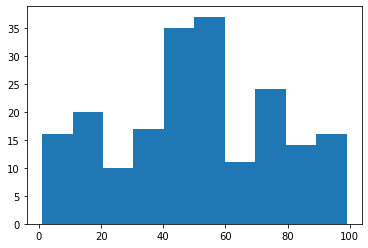

In [97]:
#Visualize distribution of target variable
plt.hist(mall_df['spending_score'])

In [98]:
#Descriptive statistics of numerical columns
mall_df.describe().T

,count,mean,std,min,25%,50%,75%,max
customer_id,200.00,100.50,57.88,1.00,50.75,100.50,150.25,200.00
age,200.00,38.85,13.97,18.00,28.75,36.00,49.00,70.00
annual_income,200.00,60.56,26.26,15.00,41.50,61.50,78.00,137.00
spending_score,200.00,50.20,25.82,1.00,34.75,50.00,73.00,99.00


In [99]:
mall_df.isna().sum()

customer_id       0
gender            0
age               0
annual_income     0
spending_score    0
dtype: int64

In [100]:
#See the quantiles for age
mall_df['age'].quantile([0.25, 0.75])

0.25                  28.75
0.75                  49.00
Name: age, dtype: float64

In [101]:
#Store the quantiles in variables
age_q1, age_q3 = mall_df['age'].quantile([0.25, 0.75])

In [102]:
#Calculate the IQR
age_iqr = age_q3 - age_q1

age_iqr

20.25

In [103]:
#Calculate upper and lower bounds based on a k value of 1.5
age_upper = age_q3 + (age_iqr * 1.5)
age_lower = age_q1 - (age_iqr * 1.5)

age_upper, age_lower

(79.375, -1.625)

In [104]:
#Check for outliers in the age column
mall_df[mall_df['age'] > age_upper]

,customer_id,gender,age,annual_income,spending_score


In [ ]:
# Question 4
# Split data into train, validate, and test.

In [105]:
#Split my data into three subsets
seed = 42

mall_train, test_val = train_test_split(mall_df, train_size=0.7,
                                   random_state=seed)

mall_test, mall_val = train_test_split(test_val, train_size=0.5,
                                       random_state=seed)

mall_train.shape, mall_val.shape, mall_test.shape

((140, 5), (30, 5), (30, 5))

In [ ]:
# Question 5
# Encode categorical columns using a one hot encoder (pd.get_dummies).

In [106]:
#Check get_dummies works as expected on my training data
pd.get_dummies(mall_train)

,customer_id,age,annual_income,spending_score,gender_Female,gender_Male
169,170,32,87,63,0,1
97,98,27,60,50,1,0
31,32,21,30,73,1,0
12,13,58,20,15,1,0
35,36,21,33,81,1,0
...,...,...,...,...,...,...
106,107,66,63,50,1,0
14,15,37,20,13,0,1
92,93,48,60,49,0,1
179,180,35,93,90,0,1


In [107]:
#Create the dataframe with dummies for gender and drop redundant column
mall_train = pd.get_dummies(mall_train)

mall_train.drop(columns=['gender_Male'], inplace=True)

mall_train.head()

,customer_id,age,annual_income,spending_score,gender_Female
169,170,32,87,63,0
97,98,27,60,50,1
31,32,21,30,73,1
12,13,58,20,15,1
35,36,21,33,81,1


In [ ]:
# Question 6
# Handle missing values.

In [108]:
#Check for missing values
mall_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140 entries, 169 to 102
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   customer_id     140 non-null    int64
 1   age             140 non-null    int64
 2   annual_income   140 non-null    int64
 3   spending_score  140 non-null    int64
 4   gender_Female   140 non-null    uint8
dtypes: int64(4), uint8(1)
memory usage: 5.6 KB


In [ ]:
# Question 7
# Scaling

In [111]:
#Initialize the scaler and fit/transform a couple columns in my training data
mms = MinMaxScaler()

mall_train[['age', 'annual_income']] = mms.fit_transform(mall_train[['age',
                                                                     'annual_income']])

mall_train.head()

,customer_id,age,annual_income,spending_score,gender_Female
169,170,0.27,0.59,63,0
97,98,0.17,0.37,50,1
31,32,0.06,0.12,73,1
12,13,0.77,0.04,15,1
35,36,0.06,0.15,81,1
